In [1]:
users_interests = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

## Recommending What's Popular

In [10]:
from collections import Counter

popular_interests = Counter(interest
                            for user_interests in users_interests
                            for interest in user_interests)

[(k, v) for k, v in popular_interests.items()][:3]

[('Hadoop', 2), ('Big Data', 3), ('HBase', 3)]

In [13]:
popular_interests.most_common()[:3]

[('Python', 4), ('R', 4), ('Big Data', 3)]

In [11]:
from typing import List, Tuple

def most_popular_new_interests(
        user_interests: List[str],
        max_results: int = 5) -> List[Tuple[str, int]]:
    suggestions = [(interest, frequency)
                   for interest, frequency in popular_interests.most_common()
                   if interest not in user_interests]
    return suggestions[:max_results]

In [14]:
most_popular_new_interests(["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"])

[('Python', 4), ('R', 4), ('Big Data', 3), ('Java', 3), ('statistics', 3)]

## User-Based Collaborative Filtering

In [15]:
unique_interests = sorted({interest
                           for user_interests in users_interests
                           for interest in user_interests})

In [16]:
def make_user_interest_vector(user_interests: List[str]) -> List[int]:
    """
    Given a list of interests, produce a vector whose ith element is 1
    if unique_interests[i] is in the list, 0 otherwise
    """
    return [1 if interest in user_interests else 0
            for interest in unique_interests]

In [19]:
user_interest_vectors = [make_user_interest_vector(user_interests)
                             for user_interests in users_interests]

In [21]:
# book code has a problem 
from scratch.linear_algebra import dot, Vector
import math

def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return dot(v1, v2) / math.sqrt(dot(v1, v1) * dot(v2, v2))

user_similarities = [[cosine_similarity(interest_vector_i, interest_vector_j)
                      for interest_vector_j in user_interest_vectors]
                     for interest_vector_i in user_interest_vectors]

In [22]:
def most_similar_users_to(user_id: int) -> List[Tuple[int, float]]:
    pairs = [(other_user_id, similarity)                      # Find other
             for other_user_id, similarity in                 # users with
                enumerate(user_similarities[user_id])         # nonzero
             if user_id != other_user_id and similarity > 0]  # similarity.

    return sorted(pairs,                                      # Sort them
                  key=lambda pair: pair[-1],                  # most similar
                  reverse=True)                               # first.

In [23]:
most_similar_users_to(0)

[(9, 0.5669467095138409),
 (1, 0.3380617018914066),
 (8, 0.1889822365046136),
 (13, 0.1690308509457033),
 (5, 0.1543033499620919)]

In [24]:
from collections import defaultdict

def user_based_suggestions(user_id: int,
                           include_current_interests: bool = False):
    # Sum up the similarities
    suggestions: Dict[str, float] = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id):
        for interest in users_interests[other_user_id]:
            suggestions[interest] += similarity

    # Convert them to a sorted list
    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[-1],  # weight
                         reverse=True)

    # And (maybe) exclude already interests
    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]

In [25]:
user_based_suggestions(0)

[('MapReduce', 0.5669467095138409),
 ('MongoDB', 0.50709255283711),
 ('Postgres', 0.50709255283711),
 ('NoSQL', 0.3380617018914066),
 ('neural networks', 0.1889822365046136),
 ('deep learning', 0.1889822365046136),
 ('artificial intelligence', 0.1889822365046136),
 ('databases', 0.1690308509457033),
 ('MySQL', 0.1690308509457033),
 ('Python', 0.1543033499620919),
 ('R', 0.1543033499620919),
 ('C++', 0.1543033499620919),
 ('Haskell', 0.1543033499620919),
 ('programming languages', 0.1543033499620919)]

## Item-Based Collaborative Filtering

In [26]:
interest_user_matrix = [[user_interest_vector[j]
                         for user_interest_vector in user_interest_vectors]
                        for j, _ in enumerate(unique_interests)]

In [27]:
interest_similarities = [[cosine_similarity(user_vector_i, user_vector_j)
                          for user_vector_j in interest_user_matrix]
                         for user_vector_i in interest_user_matrix]

In [28]:
def most_similar_interests_to(interest_id: int):
    similarities = interest_similarities[interest_id]
    pairs = [(unique_interests[other_interest_id], similarity)
             for other_interest_id, similarity in enumerate(similarities)
             if interest_id != other_interest_id and similarity > 0]
    return sorted(pairs,
                  key=lambda pair: pair[-1],
                  reverse=True)

In [29]:
most_similar_interests_to(0)

[('Hadoop', 0.8164965809277261),
 ('Java', 0.6666666666666666),
 ('MapReduce', 0.5773502691896258),
 ('Spark', 0.5773502691896258),
 ('Storm', 0.5773502691896258),
 ('Cassandra', 0.4082482904638631),
 ('artificial intelligence', 0.4082482904638631),
 ('deep learning', 0.4082482904638631),
 ('neural networks', 0.4082482904638631),
 ('HBase', 0.3333333333333333)]

In [30]:
def item_based_suggestions(user_id: int,
                           include_current_interests: bool = False):
    # Add up the similar interests
    suggestions = defaultdict(float)
    user_interest_vector = user_interest_vectors[user_id]
    for interest_id, is_interested in enumerate(user_interest_vector):
        if is_interested == 1:
            similar_interests = most_similar_interests_to(interest_id)
            for interest, similarity in similar_interests:
                suggestions[interest] += similarity

    # Sort them by weight
    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[-1],
                         reverse=True)

    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]

In [31]:
item_based_suggestions(0)

[('MapReduce', 1.861807319565799),
 ('MongoDB', 1.3164965809277263),
 ('Postgres', 1.3164965809277263),
 ('NoSQL', 1.2844570503761732),
 ('MySQL', 0.5773502691896258),
 ('databases', 0.5773502691896258),
 ('Haskell', 0.5773502691896258),
 ('programming languages', 0.5773502691896258),
 ('artificial intelligence', 0.4082482904638631),
 ('deep learning', 0.4082482904638631),
 ('neural networks', 0.4082482904638631),
 ('C++', 0.4082482904638631),
 ('Python', 0.2886751345948129),
 ('R', 0.2886751345948129)]

## Matrix Factorization

In [32]:
# This points to the current directory, modify if your files are elsewhere.
MOVIES = "scratch/ch23data/u.item"   # pipe-delimited: movie_id|title|...
RATINGS = "scratch/ch23data/u.data"  # tab-delimited: user_id, movie_id, rating, timestamp

In [33]:
from typing import NamedTuple

class Rating(NamedTuple):
    user_id: str
    movie_id: str
    rating: float

In [34]:
import csv
# We specify this encoding to avoid a UnicodeDecodeError.
# See: https://stackoverflow.com/a/53136168/1076346.
with open(MOVIES, encoding="iso-8859-1") as f:
    reader = csv.reader(f, delimiter="|")
    movies = {movie_id: title for movie_id, title, *_ in reader}

In [ ]:
# Create a list of [Rating]
with open(RATINGS, encoding="iso-8859-1") as f:
    reader = csv.reader(f, delimiter="\t")
    ratings = [Rating(user_id, movie_id, float(rating))
               for user_id, movie_id, rating, _ in reader]

# 1682 movies rated by 943 users
assert len(movies) == 1682
assert len(list({rating.user_id for rating in ratings})) == 943

ratings[:3]

In [36]:
import re

# Data structure for accumulating ratings by movie_id
star_wars_ratings = {movie_id: []
                     for movie_id, title in movies.items()
                     if re.search("Star Wars|Empire Strikes|Jedi", title)}

# Iterate over ratings, accumulating the Star Wars ones
for rating in ratings:
    if rating.movie_id in star_wars_ratings:
        star_wars_ratings[rating.movie_id].append(rating.rating)

# Compute the average rating for each movie
avg_ratings = [(sum(title_ratings) / len(title_ratings), movie_id)
               for movie_id, title_ratings in star_wars_ratings.items()]

# And then print them in order
for avg_rating, movie_id in sorted(avg_ratings, reverse=True):
    print(f"{avg_rating:.2f} {movies[movie_id]}")

4.36 Star Wars (1977)
4.20 Empire Strikes Back, The (1980)
4.01 Return of the Jedi (1983)


In [37]:
import random
random.seed(0)
random.shuffle(ratings)

split1 = int(len(ratings) * 0.7)
split2 = int(len(ratings) * 0.85)

train = ratings[:split1]              # 70% of the data
validation = ratings[split1:split2]   # 15% of the data
test = ratings[split2:]               # 15% of the data

In [38]:
avg_rating = sum(rating.rating for rating in train) / len(train)
baseline_error = sum((rating.rating - avg_rating) ** 2
                     for rating in test) / len(test)

# This is what we hope to do better than
assert 1.26 < baseline_error < 1.27

In [42]:
from scratch.deep_learning import random_tensor

EMBEDDING_DIM = 2

# Find unique ids
user_ids = {rating.user_id for rating in ratings}
movie_ids = {rating.movie_id for rating in ratings}

# Then create a random vector per id
user_vectors = {user_id: random_tensor(EMBEDDING_DIM)
                for user_id in user_ids}
movie_vectors = {movie_id: random_tensor(EMBEDDING_DIM)
                 for movie_id in movie_ids}

In [43]:
from typing import List
import tqdm
from scratch.linear_algebra import dot

def loop(dataset: List[Rating],
         learning_rate: float = None) -> None:
    with tqdm.tqdm(dataset) as t:
        loss = 0.0
        for i, rating in enumerate(t):
            movie_vector = movie_vectors[rating.movie_id]
            user_vector = user_vectors[rating.user_id]
            predicted = dot(user_vector, movie_vector)
            error = predicted - rating.rating
            loss += error ** 2

            if learning_rate is not None:
                #     predicted = m_0 * u_0 + ... + m_k * u_k
                # So each u_j enters output with coefficent m_j
                # and each m_j enters output with coefficient u_j
                user_gradient = [error * m_j for m_j in movie_vector]
                movie_gradient = [error * u_j for u_j in user_vector]

                # Take gradient steps
                for j in range(EMBEDDING_DIM):
                    user_vector[j] -= learning_rate * user_gradient[j]
                    movie_vector[j] -= learning_rate * movie_gradient[j]

            t.set_description(f"avg loss: {loss / (i + 1)}")

In [44]:
learning_rate = 0.05
for epoch in range(2):
    learning_rate *= 0.9
    print(epoch, learning_rate)
    loop(train, learning_rate=learning_rate)
    loop(validation)
loop(test)

avg loss: 15.048399707579188:   0%|          | 0/70000 [00:00<?, ?it/s]

0 0.045000000000000005


avg loss: 1.164907696740367:   0%|          | 112/70000 [00:00<01:02, 1117.82it/s] 

1 0.04050000000000001


avg loss: 0.9436234572772151:   0%|          | 200/70000 [00:00<00:35, 1989.86it/s]

2 0.03645000000000001


avg loss: 1.006321254175131:   0%|          | 142/70000 [00:00<00:49, 1416.57it/s]   

3 0.03280500000000001


avg loss: 0.8733829909801342:   0%|          | 90/70000 [00:00<01:41, 688.40it/s]

4 0.02952450000000001


avg loss: 0.8765145469122849:   0%|          | 20/70000 [00:00<05:51, 199.04it/s]s]  

5 0.02657205000000001


avg loss: 0.8339827973441427:   0%|          | 196/70000 [00:00<00:35, 1959.47it/s]

6 0.02391484500000001


avg loss: 0.9435952788225691:   4%|▍         | 2807/70000 [00:02<01:20, 838.42it/s] 

KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: 'im/working_scatter.png'

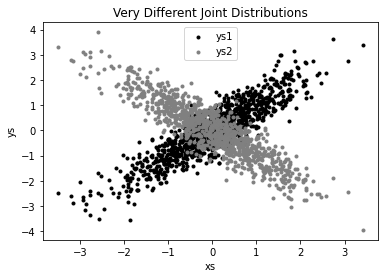

In [45]:
from scratch.working_with_data import pca, transform

original_vectors = [vector for vector in movie_vectors.values()]
components = pca(original_vectors, 2)

In [ ]:
ratings_by_movie = defaultdict(list)
for rating in ratings:
    ratings_by_movie[rating.movie_id].append(rating.rating)

vectors = [
    (movie_id,
     sum(ratings_by_movie[movie_id]) / len(ratings_by_movie[movie_id]),
     movies[movie_id],
     vector)
    for movie_id, vector in zip(movie_vectors.keys(),
                                transform(original_vectors, components))
]

# Print top 25 and bottom 25 by first principal component
print(sorted(vectors, key=lambda v: v[-1][0])[:25])
print(sorted(vectors, key=lambda v: v[-1][0])[-25:])